# Entrenamiento agente


In [ ]:
!pip install openai

# Cargar librerias
import openai
import pandas as pd
import time
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from transformers import BertModel, BertTokenizer
from torch import nn

In [ ]:
# Definición de constantes
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
NCLASSES = 4
PATH = '/kaggle/input/rewardmodel/reward4.pth'

# Carga del modelo de recompensas

In [ ]:
# DEFINICIÓN de la estructura de la red neuronal del modelo
class BERTSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(BERTSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.4)
        self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, cls_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            return_dict=False
        )
        drop_output = self.drop(cls_output)
        output = self.linear(drop_output)
        return output

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Cargar los parámetros del modelo guardado
model_loaded = BERTSentimentClassifier(NCLASSES)
model_loaded.load_state_dict(torch.load(PATH))
model_loaded.eval()
model_loaded = model_loaded.to(device)

In [ ]:
# Clasificador
def classifySentiment_loaded(utterance1,utterance2):
    encoding_review = tokenizer.encode_plus(
        utterance1,
        utterance2,
        max_length = 125,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask = True,
        return_tensors = 'pt'
        )
  
    input_ids = encoding_review['input_ids'].to(device)
    attention_mask = encoding_review['attention_mask'].to(device)
    output = model_loaded(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    
    #print('Nivel de emoción',prediction)
    return prediction  

In [ ]:
# TOKENIZACIÓN
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Ejecución algoritmo basado en REINFORCE

## Inicialización

In [ ]:
# Cálculo de la recompensa utilizando el clasificador BERT
def calc_reward(utter1,utter2):
    reward_level = [-2,-1,1,2]
    emotion_level = classifySentiment_loaded(utter1,utter2).item()
    reward = reward_level[emotion_level]
    return reward,emotion_level

In [ ]:
# Respuesta a una oración con el modelo GPT-3 entrenado
def answer_of(Tin,ft_model):
    ans = openai.Completion.create(model=ft_model, prompt=Tin, max_tokens=18, temperature=1)
    Tout = ans['choices'][0]['text']
    return Tout

In [ ]:
# Cargamos las sentencias de test que tengan un nivel de emoción menor que el máximo
# recordamos que el objetivo es conseguir una mejora en la emoción
df_test = pd.read_csv('/kaggle/input/ed-test/ED_test_p.csv',sep=";")
df_agent=df_test[df_test['emotion']!=3]

In [ ]:
df_agent.head()


In [ ]:
# Primera ejecución
episode = 0 

ft_model1 = 'ada:ft-mabel-2022-11-30-22-47-42' # El primer modelo entrenado con el set de datos de entrenamiento
ft_model2 = 'ada:ft-mabel-2022-11-30-22-47-42' # El modelo del agente 2 se inicializa con el 1

# Fichero donde se guardarán los nombres de los modelos entrenados
f = open('trained_models.txt','w')
f.write('Modelos entrenados:' + '\n')
f.write('ada:ft-mabel-2022-11-30-22-47-42'+ '\n')

In [ ]:
# Ejecuciones posteriores si cerramos sesión y ya han habido algunos capítulos de entrenamiento
episode = 10 

ft_model1 = 'ada:ft-mabel-2022-11-30-22-47-42' # El primer modelo entrenado con el set de datos de entrenamiento

# Fichero donde se guardarán los nombres de los modelos entrenados
f = open('/kaggle/working/trained_models.txt','a')

# Recuperación de variables
ft_model2 = 'ada:ft-mabel-2022-12-29-23-25-57' # Último modelo entrenado antes de cerrar sesión
retorno = [-1456, -326, 1290, 1632, 2046]

In [ ]:
openai.api_key = OPENAI_API_KEY

## Entrenamiento

In [ ]:

#NUM_EPISODES = 1
coste = 0
reward = 0 # Recompensa acumulada del episodio

# ACCION: Para cada primera oración de la base de datos de test   
for index, row in df_agent.iterrows(): 
    T1 = row['utterance']
    T1_emotion = row['emotion']
    T2 = answer_of(T1,ft_model2) # Recuperamos la respuesta a T1
    T3 = answer_of(T2,ft_model1) # Respuesta a T2
    reward_T2T3, emotion_T2T3 = calc_reward(T2,T3) # Cálculo de la recompensa y nivel de emoción de la respuesta a la respuesta
    loss = 2 - reward_T2T3 
    reward = reward + reward_T2T3

    # Guardamos en la base de datos los valores de cada iteración
    df_agent.at[index,'T1'] = T1
    df_agent.at[index,'emoT1'] = T1_emotion
    df_agent.at[index,'T2'] = T2
    df_agent.at[index,'T3'] = T3
    df_agent.at[index,'rewT2T3'] = reward_T2T3
    df_agent.at[index,'emoT2T3'] = emotion_T2T3
    df_agent.at[index,'loss'] = loss

    # Indicador de proceso
    if (index % 500) == 0:
        print('Indice:' ,index)

episode = episode + 1

# Guardar los datos del entrenamiento
agent_file = 'agent' + str(episode) + '.csv'
df_agent.to_csv(agent_file,index = False)
    
# Tomamos las lineas que han mejorado el nivel de emoción y reentrenamos el modelo GPT-3 con esas lineas
df_better = df_agent[df_agent['emoT2T3']>df_agent['emoT1']]

# Recuperamos las columnas T1 y T2
df_better_GPT3 = df_better[['T1','T2']] 

# Cambiamos el nombre de las columna para adaptar el dataset a lo que necesita GPT3
df_better_GPT3.rename(columns={'T1':'prompt','T2':'completion'},inplace=True)

# Grabar en csv 
better_file = 'better'+ str(episode) + '.csv'
df_better_GPT3.to_csv(better_file,index=False)

In [ ]:
better_file = '/kaggle/working/' + better_file
# Convertir csv a jsonl que es el formato que GPT3 necesita para reentrenar
!yes | openai tools fine_tunes.prepare_data -f better_file

In [ ]:
# Creación del file_id a partir del fichero json
better_prepared_file = '/kaggle/working/better' + str(episode) + '_prepared.jsonl'
with open(better_prepared_file) as f:
    response = openai.File.create(file=f, purpose='fine-tune')
    print(response)
    print(response['id'])    
    file_id = response['id']

In [ ]:
# El file_id se utiliza para crear el proceso de entrenamiento del modelo.
response = openai.FineTune.create(training_file=file_id, model=ft_model2)
print(response)

In [ ]:
# id del proceso del entrenamiento
id_FT = response['events'][0]['message'][-27:]
print('id_FT: ', id_FT)

In [ ]:

# Comprueba estado del entrenamiento cada 5 minutos
# cuando pasa de 'running' a 'succeeded' el proceso a terminado y 
# obtenemos el nombre del modelo generado
state = 'running'
while state != 'succeeded':  
    print("Entrenando...")
    time.sleep(300)
    response = openai.FineTune.retrieve(id=id_FT)
    state = response['status']

print("Finalizado")

In [ ]:
ft_model2 = response['fine_tuned_model']

coste = float(response['events'][1]['message'][17:])
# Guardar nombre del modelo y el coste del entrenamiento
f = open('trained_models.txt','a')
f.write(ft_model2 + ' ' + str(coste) + '\n')
f.close()

print('ft_model:', ft_model2)
print('\rEpisodio {:d} Retorno {:.2f}\t\t'.format(episode, reward), end='') 
                          
print('\nFin de entrenamiento. Coste:{:.2f} $'.format(coste))


In [ ]:
# Para comprobar el estado del entrenamiento sin necesidad 
# de esperar los 300 segundos
response = openai.FineTune.retrieve(id=id_FT)
print(response['status'])
#print(response)


# Gráficas de resultados

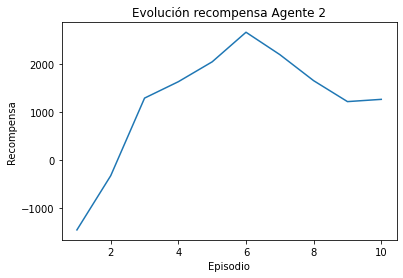

In [25]:
x = np.linspace(1, 10, 10)

plt.plot(x, reward_graph, label='Recompensa')
#Agregamos las etiquetas y añadimos una leyenda.
plt.ylabel('Recompensa')
plt.xlabel('Episodio')
plt.title("Evolución recompensa Agente 2")
plt.show()

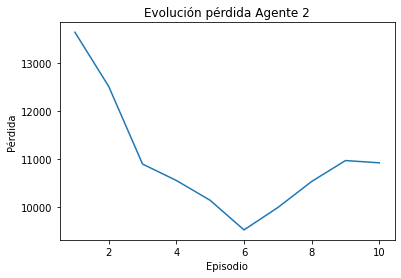

In [24]:
x = np.linspace(1, 10, 10)

plt.plot(x, loss_graph, label='Pérdida')

#Agregamos las etiquetas y añadimos una leyenda.
plt.xlabel('Episodio')
plt.ylabel('Pérdida')
plt.title("Evolución pérdida Agente 2")
plt.show()